#### Plot of expected depreciation rates according to UIP approximation
This corresponds to the spread in net yields between countries

In [ ]:
# (Re)load data
#import utils
from importlib import reload
reload(utils)
from utils import *

In [4]:
import plotly.express as px
# Plot of expected depreciation rates, starting July 2004
plot_data = spread_data[['REF_AREA','yield_spread']].copy()
plot_data = plot_data[~(plot_data['REF_AREA']).isin(
    ['DE','SE', 'FR', 'ES'] # countries to exclude
)]
plot_data.sort_values(by='REF_AREA',inplace=True)
plot_data.sort_index(inplace=True)

display(spread_data.head())

px.line(
    plot_data,
    y='yield_spread',
    line_group='REF_AREA',
    color='REF_AREA',
    labels={
        'TIME_PERIOD' : 'Time',
        'yield_spread' : 'Percentage point difference',
        'REF_AREA' : 'Country',
    },
    title='Spread btw domestic (+) and US (-) yields',
)

,Country,OBS_VALUE_yield,REF_AREA,US_yield,yield_spread
TIME_PERIOD,,,,,
2004-07-01,Great Britain,5.10830,GB,4.5,0.60830
2004-07-01,Spain,4.28150,ES,4.5,-0.21850
2004-07-01,Chile,6.43180,CL,4.5,1.93180
2004-07-01,Eurozone,4.33957,I9,4.5,-0.16043
2004-07-01,France,4.27000,FR,4.5,-0.23000


#### Plots of Nominal and real ERs vs trade as % of gdp

In [227]:
#import utils
from importlib import reload
reload(utils)
from utils import *

There are in total
0 series which do not have
the 6 digit unit multiplier.
Yields are present for the following countries: 
GB, AU, CA, CH, CL, DE, ES, I9, FR, IL, JP, KR, MX, NZ, SE, US, ZA
Only considering these ones in the analysis (data on other countries will be dropped.)


In [5]:
# Pivot goods table
import plotly.express as px
import pandas as pd

# Recreate aligned tables for Trade data
def pivot_goods_trade(df : pd.DataFrame, cnt_area : str) -> pd.DataFrame:
    exports_all = df.copy()
    exports_all = exports_all[exports_all['INDICATOR']=='Exports FOB (USD)']
    exports_all = exports_all[exports_all['CNT_AREA']==cnt_area]
    exports_all = exports_all[['REF_AREA', 'OBS_VALUE']]
    exports_all.columns = ['REF_AREA', 'Goods Exports FOB']

    imports_all = df.copy()
    imports_all = imports_all[imports_all['INDICATOR']=='Imports CIF (USD)']
    imports_all = imports_all[imports_all['CNT_AREA']==cnt_area]
    imports_all = imports_all[['REF_AREA', 'OBS_VALUE']]
    imports_all.columns = ['REF_AREA', 'Goods Imports CIF']

    tb = df.copy()
    tb = tb[tb['INDICATOR']=='Trade balance (USD)']
    tb = tb[tb['CNT_AREA']==cnt_area]
    tb = tb[['REF_AREA', 'OBS_VALUE']]
    tb.columns = ['REF_AREA', 'Goods Trade Balance']

    interim = pd.merge(
        exports_all.reset_index(), 
        imports_all.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final = pd.merge(
        interim, 
        tb.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final.set_index('TIME_PERIOD', inplace=True)
    return final

trade_goods_all = pivot_goods_trade(trade_goods, 'W1')

In [6]:
# Pivot services table
trade_services.index = trade_services.index.astype(float).astype(int)
def pivot_services_trade(df : pd.DataFrame, cnt_area : str) -> pd.DataFrame:
    export_services = df.copy()
    export_services = export_services[export_services['ACCOUNTING_ENTRY']=="C"]
    export_services = export_services[export_services['COUNTERPART_AREA']==cnt_area]
    export_services = export_services[['REF_AREA', 'OBS_VALUE']]
    export_services.columns = ['REF_AREA', 'Services Exports']

    import_services = df.copy()
    import_services = import_services[import_services['ACCOUNTING_ENTRY']=="D"]
    import_services = import_services[import_services['COUNTERPART_AREA']==cnt_area]
    import_services = import_services[['REF_AREA', 'OBS_VALUE']]
    import_services.columns = ['REF_AREA', 'Services Imports']

    tb = df.copy()
    tb = tb[tb['ACCOUNTING_ENTRY']=="B"]
    tb = tb[tb['COUNTERPART_AREA']==cnt_area]
    tb = tb[['REF_AREA', 'OBS_VALUE']]
    tb.columns = ['REF_AREA', 'Services Trade Balance']
 
    interim = pd.merge(
        export_services.reset_index(), 
        import_services.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final = pd.merge(
        interim, 
        tb.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final.set_index('TIME_PERIOD', inplace=True)
    return final

trade_services_all = pivot_services_trade(trade_services, "W1")

In [7]:
# Need to sum goods trade by year for consistency:
# make it comparable with OBS_VALUE for services

trade_goods_all_worker = trade_goods_all.copy()
trade_goods_all_worker.reset_index(inplace=True)
trade_goods_all_worker['TIME_PERIOD'] = trade_goods_all_worker['TIME_PERIOD'].apply(lambda x : x[:4])
trade_goods_all_worker = trade_goods_all_worker.groupby(["REF_AREA","TIME_PERIOD"]).sum().reset_index().set_index("TIME_PERIOD")
trade_goods_all_worker.index = trade_goods_all_worker.index.astype(float).astype(int)

all_trade = pd.merge(
    trade_goods_all_worker.reset_index(),
    trade_services_all.reset_index(),
    'inner', on=['REF_AREA','TIME_PERIOD']
).set_index("TIME_PERIOD")

# Now sum trade values across goods and services
# Also need to divide goods by 1e6 since services is in millions
all_trade['All exports']   = all_trade["Goods Exports FOB"] / 1e6 + all_trade["Services Exports"]
all_trade['All imports']   = all_trade["Goods Imports CIF"] / 1e6 + all_trade["Services Imports"]
all_trade['Trade balance'] = all_trade["Goods Trade Balance"] / 1e6 + all_trade["Services Trade Balance"]

all_trade = all_trade[["REF_AREA", "All exports", "All imports", "Trade balance"]]
all_trade.sort_index(inplace=True)
px.line(
    all_trade, y='Trade balance',
    color="REF_AREA", labels = {
        "TIME_PERIOD" : "Time",
        "REF_AREA" : "Country"
    }, title="Evolution of trade balances over time")

In [8]:
# Now plot scatter with ERs. Need to create annual series
allspotsinusd.index.name = 'TIME_PERIOD'
flat_spots = pd.melt(allspotsinusd.reset_index(),id_vars='TIME_PERIOD')
flat_spots = flat_spots.replace("I9","EU") # so we get some sort of comparison
flat_spots.columns = ['TIME_PERIOD', 'REF_AREA', 'OBS_VALUE_spot']
flat_spots['TIME_PERIOD'] = flat_spots['TIME_PERIOD'].apply(lambda date : date[:4])
flat_spots = flat_spots.groupby(["TIME_PERIOD", "REF_AREA"]).median().sort_values(["REF_AREA", "TIME_PERIOD"])
flat_spots["OBS_VALUE_USappr_rate"] = (
    flat_spots.groupby("REF_AREA")["OBS_VALUE_spot"]
    .pct_change())
flat_spots.reset_index(inplace=True)
flat_spots.dropna(how="any",axis=0)
flat_spots.set_index("TIME_PERIOD", inplace=True)
flat_spots.index = flat_spots.index.astype(float).astype(int)

er_with_trade = pd.merge(
    flat_spots.reset_index(), all_trade.reset_index(),
    'inner', on=['TIME_PERIOD','REF_AREA']
)

px.scatter(
    er_with_trade,
    x="OBS_VALUE_USappr_rate",
    y="All exports",
    color="REF_AREA",
    labels={
        "OBS_VALUE_USappr_rate" : "Foreign currency depreciation v. USD.",
        "REF_AREA" : "Country"
    })

In [9]:
# Wish to construct measure of openness and scale it by GDP
gdp_worker = gdp.copy()
gdp_worker['TIME_PERIOD'] = gdp_worker['TIME_PERIOD'].apply(lambda x : x[:4])
gdp_worker = gdp_worker.groupby(["REF_AREA", "Country", "TIME_PERIOD"]).mean()
gdp_worker.reset_index(inplace=True)
gdp_worker.set_index("TIME_PERIOD", inplace=True)
gdp_worker.index = gdp_worker.index.astype(int)

full_annual = pd.merge(
    gdp_worker.reset_index(), er_with_trade,
    'inner', on=['TIME_PERIOD','REF_AREA']
)

full_annual["Openness"] = (abs(full_annual["All exports"]) + abs(full_annual["All imports"])) / abs(full_annual["OBS_VALUE_gdp"])
full_annual.head()

,TIME_PERIOD,REF_AREA,Country,OBS_VALUE_gdp,OBS_VALUE_spot,OBS_VALUE_USappr_rate,All exports,All imports,Trade balance,Openness
0,1999,AU,Australia,492228.250,1.547509,NaN,74990.755858,91694.168570,-16703.412712,0.338633
1,2000,AU,Australia,523906.275,1.708818,0.104238,83637.015421,91536.887680,-7899.872259,0.334361
2,2001,AU,Australia,550254.450,1.938172,0.134218,81700.659212,82479.958229,-779.299017,0.298372
3,2002,AU,Australia,585379.600,1.831502,-0.055037,85294.283397,92869.015353,-7574.731956,0.304355
4,2003,AU,Australia,614027.275,1.523926,-0.167937,95398.708584,112829.867661,-17431.159077,0.339119


In [ ]:
spread_data_annual = spread_data.copy()
spread_data_annual.reset_index(inplace=True)
spread_data_annual["TIME_PERIOD"] = spread_data_annual["TIME_PERIOD"].apply(lambda date: date[:4])
spread_data_annual.groupby(["Country", "REF_AREA","TIME_PERIOD"]).mean()

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

dep_var = 'Openness'

def plot_scatter(area):
    data = full_annual[full_annual['REF_AREA'] == area].dropna(subset=['OBS_VALUE_USappr_rate', dep_var])
    x, y = data[dep_var], data['OBS_VALUE_USappr_rate']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.plot(x, p(x), 'r-', linewidth=2)
    plt.xlabel('Trade Balance')
    plt.ylabel('US Appreciation Rate')
    plt.title(f'{area}: US Appreciation Rate vs {dep_var}')
    plt.grid(True, alpha=0.3)
    plt.show()

widgets.interact(plot_scatter, area=widgets.Dropdown(options=sorted(full_annual['REF_AREA'].unique()), description='Country:'))

interactive(children=(Dropdown(description='Country:', options=('AU', 'CA', 'CH', 'JP', 'KR', 'MX', 'NZ'), val…

<function __main__.plot_scatter(area)>

NameError: name 'area' is not defined

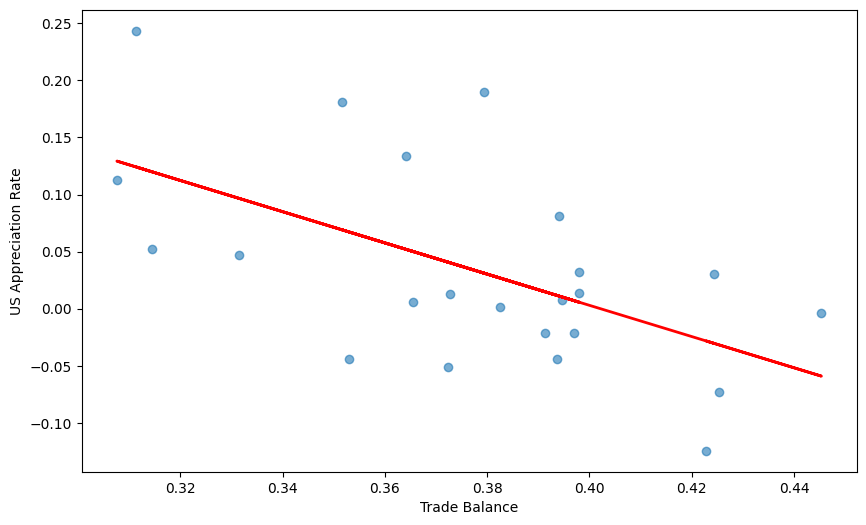

In [ ]:
# Mexico
data = full_annual[full_annual['REF_AREA'] == "MX"].dropna(subset=['OBS_VALUE_USappr_rate', dep_var])
x, y = data[dep_var], data['OBS_VALUE_USappr_rate']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, p(x), 'r-', linewidth=2)
plt.xlabel('Trade Balance')
plt.ylabel('US Appreciation Rate')
plt.title(f'MX: US Appreciation Rate vs {dep_var}')
plt.grid(True, alpha=0.3)
plt.show()

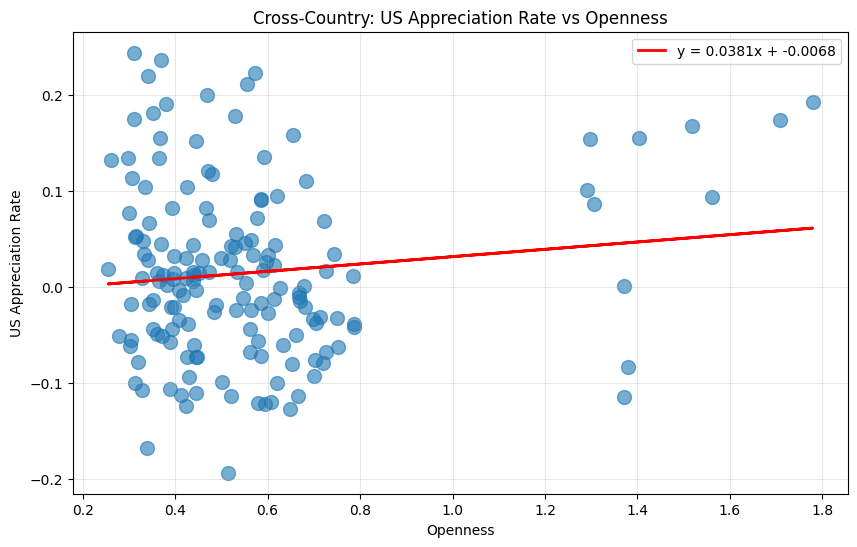

In [289]:
# Cross-country scatter: consider all observations together
all_together = full_annual.copy()
all_together = all_together[[dep_var, 'OBS_VALUE_USappr_rate']].dropna()
x, y = all_together[dep_var], all_together['OBS_VALUE_USappr_rate']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, s=100)
plt.plot(x, p(x), 'r-', linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.4f}')
plt.xlabel(dep_var)
plt.ylabel('US Appreciation Rate')
plt.title(f'Cross-Country: US Appreciation Rate vs {dep_var}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

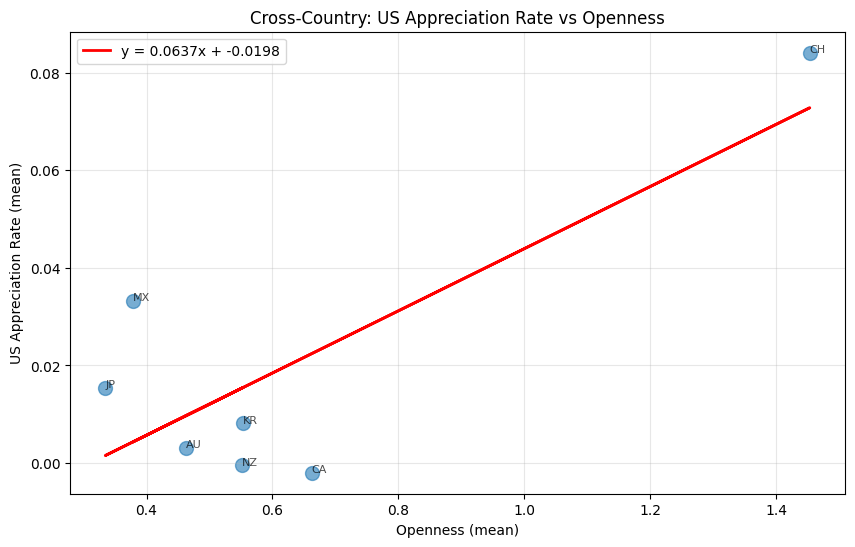

In [290]:
# Cross-country scatter: each country is one observation (time-averaged)
country_means = full_annual.groupby('REF_AREA')[['OBS_VALUE_USappr_rate',dep_var]].mean().dropna()
x, y = country_means[dep_var], country_means['OBS_VALUE_USappr_rate']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, s=100)
for area in country_means.index:
    plt.annotate(area, (country_means.loc[area, dep_var], country_means.loc[area, 'OBS_VALUE_USappr_rate']), 
                 fontsize=8, alpha=0.7)
plt.plot(x, p(x), 'r-', linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.4f}')
plt.xlabel(f'{dep_var} (mean)')
plt.ylabel('US Appreciation Rate (mean)')
plt.title(f'Cross-Country: US Appreciation Rate vs {dep_var}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [84]:
# Obtain openness to trade specifically with the US to see
# what level of penetration they have
trade_goods_US = pivot_goods_trade(trade_goods, 'US')
trade_services_US = pivot_services_trade(trade_services, "US")

trade_goods_US_worker = trade_goods_US.copy()
trade_goods_US_worker.reset_index(inplace=True)
trade_goods_US_worker['TIME_PERIOD'] = trade_goods_US_worker['TIME_PERIOD'].apply(lambda x : x[:4])
trade_goods_US_worker = trade_goods_US_worker.groupby(["REF_AREA","TIME_PERIOD"]).sum().reset_index().set_index("TIME_PERIOD")
trade_goods_US_worker.index = trade_goods_US_worker.index.astype(float).astype(int)

trade_w_US = pd.merge(
    trade_goods_US_worker.reset_index(),
    trade_services_US.reset_index(),
    'inner', on=['REF_AREA','TIME_PERIOD']
).set_index("TIME_PERIOD")

# Now sum trade values across goods and services
# Also need to divide goods by 1e6 since services is in millions
trade_w_US['All exports']   = trade_w_US["Goods Exports FOB"] / 1e6 + trade_w_US["Services Exports"]
trade_w_US['All imports']   = trade_w_US["Goods Imports CIF"] / 1e6 + trade_w_US["Services Imports"]
trade_w_US['Trade balance'] = trade_w_US["Goods Trade Balance"] / 1e6 + trade_w_US["Services Trade Balance"]

trade_w_US_worker = trade_w_US.copy()
all_trade_worker  = all_trade.copy()
trade_w_US_worker = trade_w_US_worker[[
    "REF_AREA","All exports", "All imports", "Trade balance"
]]
all_trade_worker = all_trade_worker[[
    "REF_AREA","All exports", "All imports", "Trade balance"
]]

us_penetration = pd.merge(
    trade_w_US_worker.reset_index(),
    all_trade_worker.reset_index(),
    'inner', on=['TIME_PERIOD', "REF_AREA"]
).sort_values(["REF_AREA","TIME_PERIOD"]).set_index("TIME_PERIOD")

us_penetration['US penetration'] = (
    (abs(us_penetration['All exports_x']) + \
    abs(us_penetration['All imports_x'])) / \
        (abs(us_penetration['All exports_y']) +
        abs(us_penetration['All imports_y']))
    )

us_penetration.columns = [
    "REF_AREA", "US exports", "US imports",
    "Trade balance with US", 
    "All exports","All imports","Trade balance",
    "US penetration"]

us_penetration.reset_index().sort_values(["TIME_PERIOD","US penetration"], ascending = False).head()

,TIME_PERIOD,REF_AREA,US exports,US imports,Trade balance with US,All exports,All imports,Trade balance,US penetration
98,2024,JP,198563.596579,160642.541552,37920.955027,9.355477e+05,9.894596e+05,-53911.936366,0.186600
87,2024,GB,248744.533159,150885.048117,97859.485042,1.113468e+06,1.134507e+06,-21038.716376,0.177773
125,2024,KR,160484.508000,111740.870000,48743.638000,8.225988e+05,7.944100e+05,28188.875000,0.168351
144,2024,NZ,9716.858849,7454.938208,2261.920641,6.139534e+04,6.697370e+04,-5578.367968,0.133769
24,2024,AU,26044.074312,62892.162357,-36848.088045,4.249980e+05,4.094890e+05,15509.006294,0.106576


In [293]:
px.line(
    us_penetration[us_penetration["REF_AREA"]!="CA"],
    y="US penetration",
    color="REF_AREA",
    labels={
        "REF_AREA" : "Country",
        "TIME_PERIOD" : "Time",
    }, title="US penetration in Trade for several countries, IMF data"
)

In [ ]:
import statsmodels.api as sm

# Calculate GDP growth (pct_change per country)
full_annual_sorted = full_annual.sort_values(['REF_AREA', 'TIME_PERIOD'])
full_annual_sorted['gdp_growth'] = full_annual_sorted.groupby('REF_AREA')['OBS_VALUE_gdp'].pct_change() * 100

# Prepare spread_data_annual for merge
spread_annual_clean = spread_data_annual.groupby(['REF_AREA', 'TIME_PERIOD'])['yield_spread'].mean().reset_index()
spread_annual_clean['TIME_PERIOD'] = spread_annual_clean['TIME_PERIOD'].astype(int)

# Merge with yield spreads
reg_data = pd.merge(
    full_annual_sorted.reset_index(drop=True),
    spread_annual_clean,
    on=['REF_AREA', 'TIME_PERIOD'],
    how='inner'
).dropna(subset=['gdp_growth', 'yield_spread', 'Openness'])

# Create interaction model: gdp_growth ~ yield_spread + country_FE + (yield_spread × country_FE)
country_dummies = pd.get_dummies(reg_data['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions = country_dummies.multiply(reg_data['yield_spread'].values, axis=0)
interactions.columns = [col + '_x_spread' for col in interactions.columns]

X = pd.concat([reg_data[['yield_spread', 'Openness']].reset_index(drop=True), country_dummies.reset_index(drop=True), interactions.reset_index(drop=True)], axis=1)
X = sm.add_constant(X)
y = reg_data['gdp_growth'].reset_index(drop=True)

model = sm.OLS(y, X).fit()
print(model.summary())

# Print country-specific yield spread coefficients
print('\n' + '='*80)
print('COUNTRY-SPECIFIC YIELD SPREAD COEFFICIENTS')
print('='*80)
base_coef = model.params['yield_spread']
print(f"Base country: {base_coef:.6f}")
for col in interactions.columns:
    country = col.replace('REF_AREA_', '').replace('_x_spread', '')
    total_coef = base_coef + model.params[col]
    print(f"{country}: {total_coef:.6f}")

In [53]:
inflation_annual = inflation.copy()
inflation_annual.reset_index(inplace=True)
inflation_annual["TIME_PERIOD"] = inflation_annual["TIME_PERIOD"].apply(lambda date: date[:4])
inflation_annual.groupby(["REF_AREA","TIME_PERIOD"]).mean().reset_index(inplace=True)
inflation_annual['TIME_PERIOD'] = inflation_annual['TIME_PERIOD'].astype(int)

price_indices_annual = price_indices.copy()
price_indices_annual.reset_index(inplace=True)
price_indices_annual["TIME_PERIOD"] = price_indices_annual["TIME_PERIOD"].apply(lambda date: date[:4])
price_indices_annual.groupby(["REF_AREA","TIME_PERIOD"]).mean().reset_index(inplace=True)
price_indices_annual['TIME_PERIOD'] = price_indices_annual['TIME_PERIOD'].astype(int)

In [69]:
# a) GDP Levels regression
print('='*80)
print('GDP LEVELS: INTERACTION MODEL')
print('='*80)

reg_gdp_levels = pd.merge(
    full_annual_sorted[['REF_AREA', 'TIME_PERIOD', 'OBS_VALUE_gdp', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True),
    spread_annual_clean,
    on=['REF_AREA', 'TIME_PERIOD'],
    how='inner'
).dropna(subset=['OBS_VALUE_gdp', 'yield_spread', 'Openness'])

country_dummies_gdp = pd.get_dummies(reg_gdp_levels['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_gdp = country_dummies_gdp.multiply(reg_gdp_levels['yield_spread'].values, axis=0)
interactions_gdp.columns = [col + '_x_spread' for col in interactions_gdp.columns]

X_gdp = pd.concat([reg_gdp_levels[['yield_spread', 'Openness']].reset_index(drop=True), country_dummies_gdp.reset_index(drop=True), interactions_gdp.reset_index(drop=True)], axis=1)
X_gdp = sm.add_constant(X_gdp)
y_gdp = reg_gdp_levels['OBS_VALUE_gdp'].reset_index(drop=True)

model_gdp = sm.OLS(y_gdp, X_gdp).fit()
print(model_gdp.summary())

print('\n' + '='*80)
print('GDP LEVELS: COUNTRY-SPECIFIC COEFFICIENTS')
print('='*80)
base_coef_gdp = model_gdp.params['yield_spread']
print(f"Base: {base_coef_gdp:.6f}")
for col in interactions_gdp.columns:
    country = col.replace('REF_AREA_', '').replace('_x_spread', '')
    print(f"{country}: {base_coef_gdp + model_gdp.params[col]:.6f}")

GDP LEVELS: INTERACTION MODEL
                            OLS Regression Results                            
Dep. Variable:          OBS_VALUE_gdp   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     115.7
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           5.44e-63
Time:                        21:36:31   Log-Likelihood:                -1950.7
No. Observations:                 136   AIC:                             3931.
Df Residuals:                     121   BIC:                             3975.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

In [45]:
# b) Inflation regression
print('='*80)
print('INFLATION: INTERACTION MODEL')
print('='*80)

inflation_clean = pd.merge(
    inflation_annual, full_annual_sorted,
    how='inner', on=['REF_AREA', 'TIME_PERIOD'],
)
inflation_clean['TIME_PERIOD'] = inflation_clean['TIME_PERIOD'].astype(int)

reg_inflation = pd.merge(
    inflation_clean,
    spread_annual_clean,
    on=['REF_AREA', 'TIME_PERIOD'],
    how='inner'
).dropna(subset=['OBS_VALUE_inflation', 'yield_spread', 'Openness'])

country_dummies_inf = pd.get_dummies(reg_inflation['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_inf = country_dummies_inf.multiply(reg_inflation['yield_spread'].values, axis=0)
interactions_inf.columns = [col + '_x_spread' for col in interactions_inf.columns]

X_inf = pd.concat([reg_inflation[['yield_spread', 'Openness']].reset_index(drop=True), country_dummies_inf.reset_index(drop=True), interactions_inf.reset_index(drop=True)], axis=1)
X_inf = sm.add_constant(X_inf)
y_inf = reg_inflation['OBS_VALUE_inflation'].reset_index(drop=True)

model_inf = sm.OLS(y_inf, X_inf).fit()
print(model_inf.summary())

print('\n' + '='*80)
print('INFLATION: COUNTRY-SPECIFIC COEFFICIENTS')
print('='*80)
base_coef_inf = model_inf.params['yield_spread']
print(f"Base: {base_coef_inf:.6f}")
for col in interactions_inf.columns:
    country = col.replace('REF_AREA_', '').replace('_x_spread', '')
    print(f"{country}: {base_coef_inf + model_inf.params[col]:.6f}")

INFLATION: INTERACTION MODEL
                             OLS Regression Results                            
Dep. Variable:     OBS_VALUE_inflation   R-squared:                       0.606
Model:                             OLS   Adj. R-squared:                  0.602
Method:                  Least Squares   F-statistic:                     147.5
Date:                 Mon, 17 Nov 2025   Prob (F-statistic):          6.37e-223
Time:                         21:03:31   Log-Likelihood:                -1914.0
No. Observations:                 1165   AIC:                             3854.
Df Residuals:                     1152   BIC:                             3920.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [ ]:
# c) Price Indices regression
print('='*80)
print('PRICE INDICES: INTERACTION MODEL')
print('='*80)

price_clean = pd.merge(
    price_indices_annual, full_annual_sorted,
    how='inner', on=['REF_AREA', 'TIME_PERIOD'],
)
price_clean['TIME_PERIOD'] = price_clean['TIME_PERIOD'].astype(int)

reg_price = pd.merge(
    price_clean,
    spread_annual_clean,
    on=['REF_AREA', 'TIME_PERIOD'],
    how='inner'
).dropna(subset=['OBS_VALUE_price', 'yield_spread', 'Openness'])

country_dummies_price = pd.get_dummies(reg_price['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_price = country_dummies_price.multiply(reg_price['yield_spread'].values, axis=0)
interactions_price.columns = [col + '_x_spread' for col in interactions_price.columns]

X_price = pd.concat([reg_price[['yield_spread', 'Openness']].reset_index(drop=True), country_dummies_price.reset_index(drop=True), interactions_price.reset_index(drop=True)], axis=1)
X_price = sm.add_constant(X_price)
y_price = reg_price['OBS_VALUE_price'].reset_index(drop=True)

model_price = sm.OLS(y_price, X_price).fit()
print(model_price.summary())

print('\n' + '='*80)
print('PRICE INDICES: COUNTRY-SPECIFIC COEFFICIENTS')
print('='*80)
base_coef_price = model_price.params['yield_spread']
print(f"Base: {base_coef_price:.6f}")
for col in interactions_price.columns:
    country = col.replace('REF_AREA_', '').replace('_x_spread', '')
    print(f"{country}: {base_coef_price + model_price.params[col]:.6f}")

from stargazer.stargazer import Stargazer

# For a single model
stargazer = Stargazer([model])
print(stargazer.render_latex())

# For multiple models side-by-side
stargazer = Stargazer([model, model_gdp, model_inf, model_price])
latex_output = stargazer.render_latex()
latex_output = latex_output.replace('_', '\\_')
print(latex_output)

PRICE INDICES: INTERACTION MODEL
                            OLS Regression Results                            
Dep. Variable:        OBS_VALUE_price   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     35.68
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           1.91e-60
Time:                        21:05:56   Log-Likelihood:                -4265.2
No. Observations:                1081   AIC:                             8552.
Df Residuals:                    1070   BIC:                             8607.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
# Regressions with yield_spread, Openness, USappr_rate, and country FE (NO interactions)

# 1. GDP Growth
reg_data_simple = reg_data[['gdp_growth', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_simple = pd.get_dummies(reg_data_simple['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_simple = pd.concat([reg_data_simple[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True), country_dummies_simple.reset_index(drop=True)], axis=1)
X_simple = sm.add_constant(X_simple)
y_simple = reg_data_simple['gdp_growth'].reset_index(drop=True)
model_simple = sm.OLS(y_simple, X_simple).fit()

# 2. GDP Levels
reg_gdp_simple = reg_gdp_levels[['OBS_VALUE_gdp', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_gdp_simple = pd.get_dummies(reg_gdp_simple['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_gdp_simple = pd.concat([reg_gdp_simple[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True), country_dummies_gdp_simple.reset_index(drop=True)], axis=1)
X_gdp_simple = sm.add_constant(X_gdp_simple)
y_gdp_simple = reg_gdp_simple['OBS_VALUE_gdp'].reset_index(drop=True)
model_gdp_simple = sm.OLS(y_gdp_simple, X_gdp_simple).fit()

# 3. Inflation
reg_inf_simple = pd.merge(reg_inflation, full_annual[['REF_AREA', 'TIME_PERIOD']], on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_inf_simple = reg_inf_simple[['OBS_VALUE_inflation', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_inf_simple = pd.get_dummies(reg_inf_simple['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_inf_simple = pd.concat([reg_inf_simple[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True), country_dummies_inf_simple.reset_index(drop=True)], axis=1)
X_inf_simple = sm.add_constant(X_inf_simple)
y_inf_simple = reg_inf_simple['OBS_VALUE_inflation'].reset_index(drop=True)
model_inf_simple = sm.OLS(y_inf_simple, X_inf_simple).fit()

# 4. Price Indices
reg_price_simple = pd.merge(reg_price, full_annual[['REF_AREA', 'TIME_PERIOD']], on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_price_simple = reg_price_simple[['OBS_VALUE_price', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_price_simple = pd.get_dummies(reg_price_simple['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_price_simple = pd.concat([reg_price_simple[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True), country_dummies_price_simple.reset_index(drop=True)], axis=1)
X_price_simple = sm.add_constant(X_price_simple)
y_price_simple = reg_price_simple['OBS_VALUE_price'].reset_index(drop=True)
model_price_simple = sm.OLS(y_price_simple, X_price_simple).fit()

# Generate LaTeX table
from stargazer.stargazer import Stargazer
stargazer_simple = Stargazer([model_simple, model_gdp_simple, model_inf_simple, model_price_simple])
latex_simple = stargazer_simple.render_latex()
latex_simple = latex_simple.replace('_', '\\_').replace('$^{}$', '')
print(latex_simple)

In [ ]:
# 1. GDP Growth
reg_data_interact = reg_data[['gdp_growth', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_interact = pd.get_dummies(reg_data_interact['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_interact = country_dummies_interact.multiply(reg_data_interact['yield_spread'].values, axis=0)
interactions_interact.columns = [col + '_x_spread' for col in interactions_interact.columns]
X_interact = pd.concat([
    reg_data_interact[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True),
    country_dummies_interact.reset_index(drop=True),
    interactions_interact.reset_index(drop=True)
], axis=1)
X_interact = sm.add_constant(X_interact)
y_interact = reg_data_interact['gdp_growth'].reset_index(drop=True)
model_interact = sm.OLS(y_interact, X_interact).fit()

# 2. GDP Levels
reg_gdp_interact = reg_gdp_levels[['OBS_VALUE_gdp', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_gdp_interact = pd.get_dummies(reg_gdp_interact['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_gdp_interact = country_dummies_gdp_interact.multiply(reg_gdp_interact['yield_spread'].values, axis=0)
interactions_gdp_interact.columns = [col + '_x_spread' for col in interactions_gdp_interact.columns]
X_gdp_interact = pd.concat([
    reg_gdp_interact[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True),
    country_dummies_gdp_interact.reset_index(drop=True),
    interactions_gdp_interact.reset_index(drop=True)
], axis=1)
X_gdp_interact = sm.add_constant(X_gdp_interact)
y_gdp_interact = reg_gdp_interact['OBS_VALUE_gdp'].reset_index(drop=True)
model_gdp_interact = sm.OLS(y_gdp_interact, X_gdp_interact).fit()

# 3. Inflation
reg_inf_interact = pd.merge(
    reg_inflation,
    full_annual[['REF_AREA', 'TIME_PERIOD']],
    on=['REF_AREA', 'TIME_PERIOD'],
    how='left'
)
reg_inf_interact = reg_inf_interact[['OBS_VALUE_inflation', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_inf_interact = pd.get_dummies(reg_inf_interact['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_inf_interact = country_dummies_inf_interact.multiply(reg_inf_interact['yield_spread'].values, axis=0)
interactions_inf_interact.columns = [col + '_x_spread' for col in interactions_inf_interact.columns]
X_inf_interact = pd.concat([
    reg_inf_interact[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True),
    country_dummies_inf_interact.reset_index(drop=True),
    interactions_inf_interact.reset_index(drop=True)
], axis=1)
X_inf_interact = sm.add_constant(X_inf_interact)
y_inf_interact = reg_inf_interact['OBS_VALUE_inflation'].reset_index(drop=True)
model_inf_interact = sm.OLS(y_inf_interact, X_inf_interact).fit()

# 4. Price Indices
reg_price_interact = pd.merge(
    reg_price,
    full_annual[['REF_AREA', 'TIME_PERIOD']],
    on=['REF_AREA', 'TIME_PERIOD'],
    how='left'
)
reg_price_interact = reg_price_interact[['OBS_VALUE_price', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
country_dummies_price_interact = pd.get_dummies(reg_price_interact['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
interactions_price_interact = country_dummies_price_interact.multiply(reg_price_interact['yield_spread'].values, axis=0)
interactions_price_interact.columns = [col + '_x_spread' for col in interactions_price_interact.columns]
X_price_interact = pd.concat([
    reg_price_interact[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate']].reset_index(drop=True),
    country_dummies_price_interact.reset_index(drop=True),
    interactions_price_interact.reset_index(drop=True)
], axis=1)
X_price_interact = sm.add_constant(X_price_interact)
y_price_interact = reg_price_interact['OBS_VALUE_price'].reset_index(drop=True)
model_price_interact = sm.OLS(y_price_interact, X_price_interact).fit()

# Generate LaTeX table
stargazer_interact = Stargazer([model_interact, model_gdp_interact, model_inf_interact, model_price_interact])
latex_interact = stargazer_interact.render_latex()
latex_interact = latex_interact.replace('_', '\\_').replace('$^{}$', '')
print(latex_interact)


In [92]:
# Regressions with yield_spread, Openness, USappr_rate, US penetration, country FE, and yield_spread × US penetration interaction

# Prepare US penetration data
us_pen_clean = us_penetration[['REF_AREA', 'US penetration']].reset_index()
us_pen_clean['TIME_PERIOD'] = us_pen_clean['TIME_PERIOD'].astype(int)

# 1. GDP Growth
reg_data_uspen = pd.merge(reg_data.reset_index(), us_pen_clean, on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_data_uspen = reg_data_uspen[['gdp_growth', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'REF_AREA']].dropna()
reg_data_uspen['spread_x_uspen'] = reg_data_uspen['yield_spread'] * reg_data_uspen['US penetration']
country_dummies_uspen = pd.get_dummies(reg_data_uspen['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_uspen = pd.concat([
    reg_data_uspen[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'spread_x_uspen']].reset_index(drop=True),
    country_dummies_uspen.reset_index(drop=True)
], axis=1)
X_uspen = sm.add_constant(X_uspen)
y_uspen = reg_data_uspen['gdp_growth'].reset_index(drop=True)
model_uspen = sm.OLS(y_uspen, X_uspen).fit()

# 2. GDP Levels
reg_gdp_uspen = pd.merge(reg_gdp_levels.reset_index(), us_pen_clean, on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_gdp_uspen = reg_gdp_uspen[['OBS_VALUE_gdp', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'REF_AREA']].dropna()
reg_gdp_uspen['spread_x_uspen'] = reg_gdp_uspen['yield_spread'] * reg_gdp_uspen['US penetration']
country_dummies_gdp_uspen = pd.get_dummies(reg_gdp_uspen['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_gdp_uspen = pd.concat([
    reg_gdp_uspen[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'spread_x_uspen']].reset_index(drop=True),
    country_dummies_gdp_uspen.reset_index(drop=True)
], axis=1)
X_gdp_uspen = sm.add_constant(X_gdp_uspen)
y_gdp_uspen = reg_gdp_uspen['OBS_VALUE_gdp'].reset_index(drop=True)
model_gdp_uspen = sm.OLS(y_gdp_uspen, X_gdp_uspen).fit()

# 3. Inflation
reg_inf_uspen = pd.merge(reg_inflation.reset_index(), us_pen_clean, on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_inf_uspen = pd.merge(
    reg_inf_uspen,
    full_annual[['REF_AREA', 'TIME_PERIOD']],
    on=['REF_AREA', 'TIME_PERIOD'],
    how='left'
)
reg_inf_uspen = reg_inf_uspen[['OBS_VALUE_inflation', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'REF_AREA']].dropna()
reg_inf_uspen['spread_x_uspen'] = reg_inf_uspen['yield_spread'] * reg_inf_uspen['US penetration']
country_dummies_inf_uspen = pd.get_dummies(reg_inf_uspen['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_inf_uspen = pd.concat([
    reg_inf_uspen[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'spread_x_uspen']].reset_index(drop=True),
    country_dummies_inf_uspen.reset_index(drop=True)
], axis=1)
X_inf_uspen = sm.add_constant(X_inf_uspen)
y_inf_uspen = reg_inf_uspen['OBS_VALUE_inflation'].reset_index(drop=True)
model_inf_uspen = sm.OLS(y_inf_uspen, X_inf_uspen).fit()

# 4. Price Indices
reg_price_uspen = pd.merge(reg_price.reset_index(), us_pen_clean, on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_price_uspen = pd.merge(
    reg_price_uspen,
    full_annual[['REF_AREA', 'TIME_PERIOD']],
    on=['REF_AREA', 'TIME_PERIOD'],
    how='left'
)
reg_price_uspen = reg_price_uspen[['OBS_VALUE_price', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'REF_AREA']].dropna()
reg_price_uspen['spread_x_uspen'] = reg_price_uspen['yield_spread'] * reg_price_uspen['US penetration']
country_dummies_price_uspen = pd.get_dummies(reg_price_uspen['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_price_uspen = pd.concat([
    reg_price_uspen[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'US penetration', 'spread_x_uspen']].reset_index(drop=True),
    country_dummies_price_uspen.reset_index(drop=True)
], axis=1)
X_price_uspen = sm.add_constant(X_price_uspen)
y_price_uspen = reg_price_uspen['OBS_VALUE_price'].reset_index(drop=True)
model_price_uspen = sm.OLS(y_price_uspen, X_price_uspen).fit()

# Generate LaTeX table
stargazer_uspen = Stargazer([model_uspen, model_gdp_uspen, model_inf_uspen, model_price_uspen])
latex_uspen = stargazer_uspen.render_latex()
latex_uspen = latex_uspen.replace('_', '\\_').replace('$^{}$', '')
print(latex_uspen)

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 OBS\_VALUE\_USappr\_rate & -8.604$^{*}$ & 530022.305 & 0.682 & 26.433$^{***}$ \\
& (4.934) & (477335.669) & (0.798) & (5.345) \\
 Openness & -2.007 & -614522.663 & -0.251 & -30.619$^{***}$ \\
& (6.010) & (581468.088) & (0.854) & (5.503) \\
 REF\_AREA\_CA & -0.627 & 3493877.768$^{***}$ & -1.270 & \\
& (13.101) & (1267560.394) & (1.580) & \\
 REF\_AREA\_JP & -5.201$^{**}$ & 3847727.944$^{***}$ & -1.333$^{***}$ & -112.161$^{***}$ \\
& (2.528) & (244547.937) & (0.356) & (8.891) \\
 REF\_AREA\_KR & -0.750 & 1075043.976$^{***}$ & -0.289 & -95.765$^{***}$ \\
& (1.643) & (158922.456) & (0.233) & (8.911) \\
 REF\_AREA\_NZ & 0.217 & -763208.321$^{***}$ & & \\
& (1.273) & (123141.710) & & \\
 US penetration & -0.584 & -6142861.448$^{**}$ & 1.935 & -198.866$^{***}$ \\
& (24.118) & (2333453.872) & (2.919) & (18.030) \\
 const & 7.475$

In [ ]:
# Regressions with yield_spread × Openness interaction (NOT spread × country FE)

# 1. GDP Growth
reg_data_open_int = reg_data[['gdp_growth', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
reg_data_open_int['spread_x_openness'] = reg_data_open_int['yield_spread'] * reg_data_open_int['Openness']
country_dummies_open_int = pd.get_dummies(reg_data_open_int['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_open_int = pd.concat([
    reg_data_open_int[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'spread_x_openness']].reset_index(drop=True),
    country_dummies_open_int.reset_index(drop=True)
], axis=1)
X_open_int = sm.add_constant(X_open_int)
y_open_int = reg_data_open_int['gdp_growth'].reset_index(drop=True)
model_open_int = sm.OLS(y_open_int, X_open_int).fit()

# 2. GDP Levels
reg_gdp_open_int = reg_gdp_levels[['OBS_VALUE_gdp', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
reg_gdp_open_int['spread_x_openness'] = reg_gdp_open_int['yield_spread'] * reg_gdp_open_int['Openness']
country_dummies_gdp_open_int = pd.get_dummies(reg_gdp_open_int['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_gdp_open_int = pd.concat([
    reg_gdp_open_int[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'spread_x_openness']].reset_index(drop=True),
    country_dummies_gdp_open_int.reset_index(drop=True)
], axis=1)
X_gdp_open_int = sm.add_constant(X_gdp_open_int)
y_gdp_open_int = reg_gdp_open_int['OBS_VALUE_gdp'].reset_index(drop=True)
model_gdp_open_int = sm.OLS(y_gdp_open_int, X_gdp_open_int).fit()

# 3. Inflation
reg_inf_open_int = pd.merge(reg_inflation, full_annual[['REF_AREA', 'TIME_PERIOD']], on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_inf_open_int = reg_inf_open_int[['OBS_VALUE_inflation', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
reg_inf_open_int['spread_x_openness'] = reg_inf_open_int['yield_spread'] * reg_inf_open_int['Openness']
country_dummies_inf_open_int = pd.get_dummies(reg_inf_open_int['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_inf_open_int = pd.concat([
    reg_inf_open_int[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'spread_x_openness']].reset_index(drop=True),
    country_dummies_inf_open_int.reset_index(drop=True)
], axis=1)
X_inf_open_int = sm.add_constant(X_inf_open_int)
y_inf_open_int = reg_inf_open_int['OBS_VALUE_inflation'].reset_index(drop=True)
model_inf_open_int = sm.OLS(y_inf_open_int, X_inf_open_int).fit()

# 4. Price Indices
reg_price_open_int = pd.merge(reg_price, full_annual[['REF_AREA', 'TIME_PERIOD']], on=['REF_AREA', 'TIME_PERIOD'], how='left')
reg_price_open_int = reg_price_open_int[['OBS_VALUE_price', 'yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'REF_AREA']].dropna()
reg_price_open_int['spread_x_openness'] = reg_price_open_int['yield_spread'] * reg_price_open_int['Openness']
country_dummies_price_open_int = pd.get_dummies(reg_price_open_int['REF_AREA'], prefix='REF_AREA', drop_first=True).astype(float)
X_price_open_int = pd.concat([
    reg_price_open_int[['yield_spread', 'Openness', 'OBS_VALUE_USappr_rate', 'spread_x_openness']].reset_index(drop=True),
    country_dummies_price_open_int.reset_index(drop=True)
], axis=1)
X_price_open_int = sm.add_constant(X_price_open_int)
y_price_open_int = reg_price_open_int['OBS_VALUE_price'].reset_index(drop=True)
model_price_open_int = sm.OLS(y_price_open_int, X_price_open_int).fit()

# Generate LaTeX table
stargazer_open_int = Stargazer([model_open_int, model_gdp_open_int, model_inf_open_int, model_price_open_int])
latex_open_int = stargazer_open_int.render_latex()
latex_open_int = latex_open_int.replace('_', '\\_').replace('$^{}$', '')
print(latex_open_int)
